In [1]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = "datasets/housing"
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + "/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        print("path doesn't exit, creating dir now")
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()


In [2]:
fetch_housing_data()

In [3]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

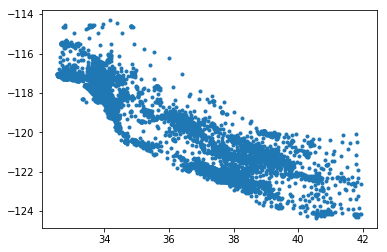

In [6]:
%matplotlib inline
from matplotlib import pyplot as plt

xs = housing["latitude"].values
ys = housing["longitude"].values

plt.plot(xs,ys, '.')


In [7]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x114d71cf8>,
      dtype=object)

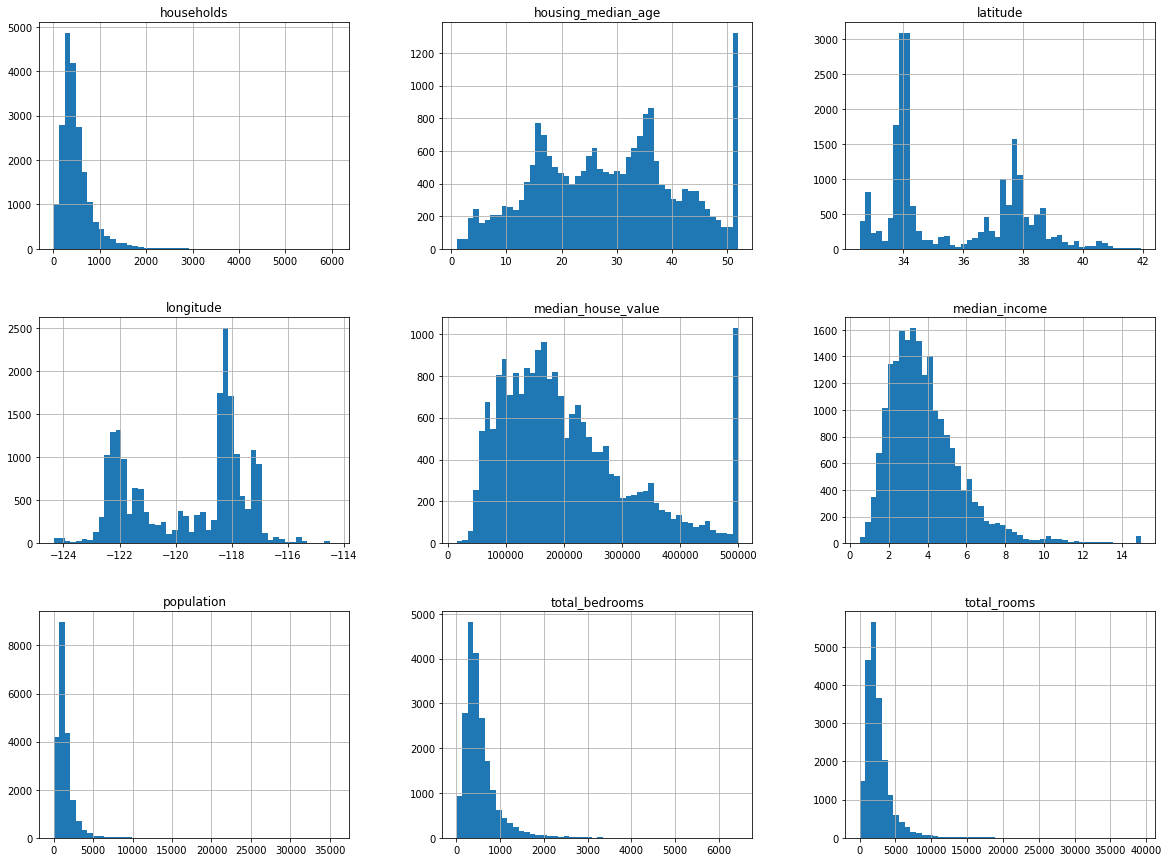

In [8]:
housing.hist(bins=50, figsize=(20,15))

In [9]:
import numpy as np
def split_train_test(data, test_ratio):
    """Segment test and train set. Not a fully working answer, as
    each time it will come up with a different set, and eventually
    the ML algorithm will see all of the data"""
    shuffled_indicies = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indicies = shuffled_indicies[:test_set_size]
    train_indicies = shuffled_indicies[test_set_size:]
    return data.iloc[train_indicies], data.iloc[test_indicies]

# Usage:
train_set, test_set = split_train_test(housing, 0.2)
print("{} train + {} test".format(len(train_set), len(test_set)))

16512 train + 4128 test


In [10]:
# Solution using each instance's identify the test set
# Assumes unique immutable identifier
# Compute a hash of each instance's identifier, keeping only the last byte of the hash

import hashlib

def test_set_check(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

# Add an index column
housing_with_id = housing.reset_index()

train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

# print(train_set, test_set) # Dont peek

# doing the same operation, but using a stable row as an identifier
housing_with_id['id'] = housing['longitude']*1000 + housing['latitude']
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, 'id')


# # the full set:
# print(housing_with_id["income_cat"].value_counts() / len(housing))

# # the test set:
# print(test_set["income_cat"].value_counts() / len(test_set))
# print(train_set["income_cat"].value_counts() / len(train_set))

In [11]:
list_it = pd.Series([hash(np.int64(i+1)) for i in range(5,30)])
rnd_indicies = np.random.permutation(int(0.67*len(list_it)))
# list_it
print("list_it: ", list_it)
print("rnd_indicies: ", rnd_indicies)
# The random indicies
# print(list_it.loc[rnd_indicies])
# print(list_it.loc[~rnd_indicies])
# plt.plot(list_it.loc[rnd_indicies], list_it.loc[~rnd_indicies])

list_it:  0      6
1      7
2      8
3      9
4     10
5     11
6     12
7     13
8     14
9     15
10    16
11    17
12    18
13    19
14    20
15    21
16    22
17    23
18    24
19    25
20    26
21    27
22    28
23    29
24    30
dtype: int64
rnd_indicies:  [ 3  2  1 15 12 13  0  9 11  8 10  5  4  6 14  7]


In [12]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=444517870)

In [13]:
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"]<5, 5.0, inplace=True)


In [14]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=4929285)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [15]:
# Lets see if that worked

# the full set:
print(housing["income_cat"].value_counts() / len(housing))

# the test set:
print(strat_test_set["income_cat"].value_counts() / len(strat_test_set))
print(strat_train_set["income_cat"].value_counts() / len(strat_train_set))

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64
3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64
3.0    0.350594
2.0    0.318859
4.0    0.176296
5.0    0.114402
1.0    0.039850
Name: income_cat, dtype: float64


In [16]:
for set in (strat_train_set, strat_test_set):
    set.drop(['income_cat'], axis=1, inplace=True)

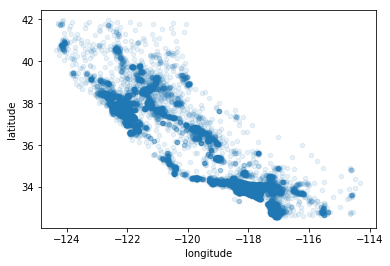

In [17]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1)

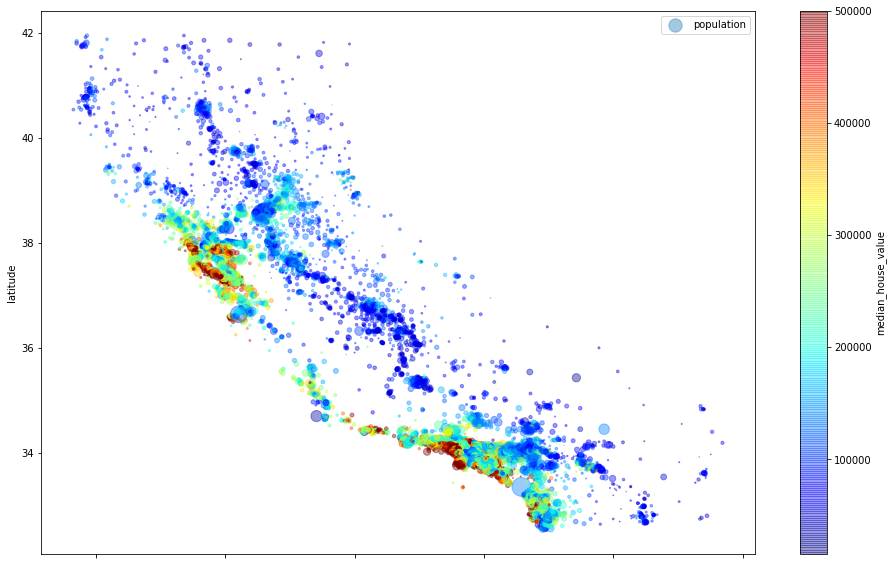

In [18]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4,
            s=housing['population']/100, label='population',
             c='median_house_value', cmap=plt.get_cmap('jet'), colorbar=True, figsize=(16,10))
plt.legend()

In [19]:
corr_matrix = housing.corr()

In [20]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
income_cat            0.643892
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

In [21]:
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,income_cat
longitude,1.000000,-0.924664,-0.108197,0.044568,0.069608,0.099773,0.055310,-0.015176,-0.045967,-0.010690
latitude,-0.924664,1.000000,0.011173,-0.036100,-0.066983,-0.108785,-0.071035,-0.079809,-0.144160,-0.085528
housing_median_age,-0.108197,0.011173,1.000000,-0.361262,-0.320451,-0.296244,-0.302916,-0.119034,0.105623,-0.146920
total_rooms,0.044568,-0.036100,-0.361262,1.000000,0.930380,0.857126,0.918484,0.198050,0.134153,0.220528
total_bedrooms,0.069608,-0.066983,-0.320451,0.930380,1.000000,0.877747,0.979728,-0.007723,0.049686,0.015662
population,0.099773,-0.108785,-0.296244,0.857126,0.877747,1.000000,0.907222,0.004834,-0.024650,0.025809
households,0.055310,-0.071035,-0.302916,0.918484,0.979728,0.907222,1.000000,0.013033,0.065843,0.038490
median_income,-0.015176,-0.079809,-0.119034,0.198050,-0.007723,0.004834,0.013033,1.000000,0.688075,0.902750
median_house_value,-0.045967,-0.144160,0.105623,0.134153,0.049686,-0.024650,0.065843,0.688075,1.000000,0.643892
income_cat,-0.010690,-0.085528,-0.146920,0.220528,0.015662,0.025809,0.038490,0.902750,0.643892,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x120a132b0>,
      dtype=object)

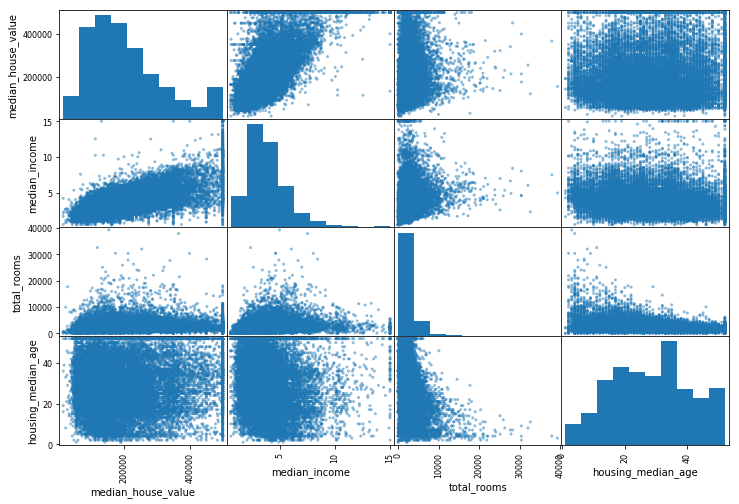

In [22]:
from pandas.plotting import scatter_matrix

attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
scatter_matrix(housing[attributes], figsize=(12, 8))

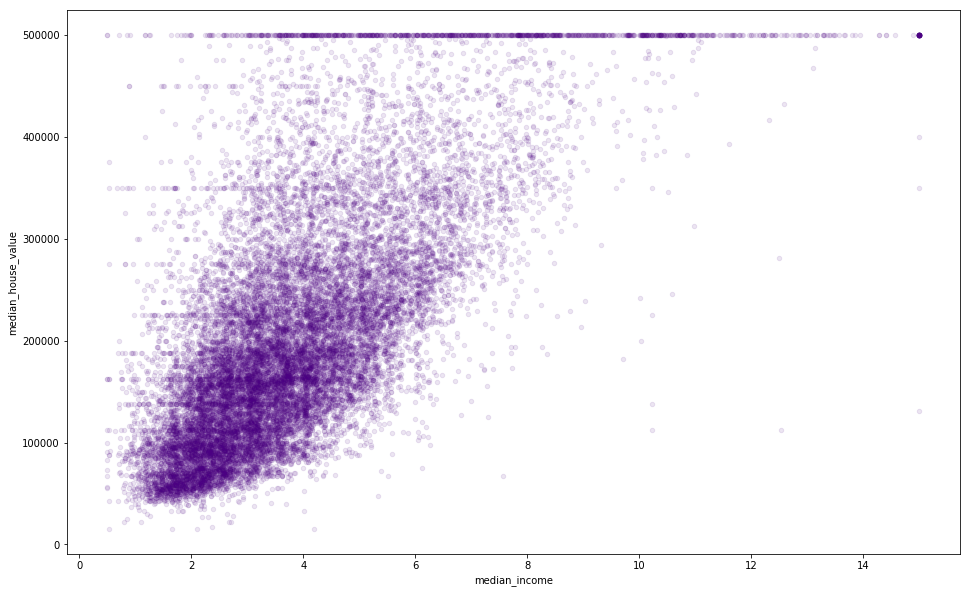

In [23]:
housing.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1, figsize=(16,10), c='indigo')

In [24]:
housing['rooms_per_houshold'] = housing['total_rooms']/housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms']/housing['total_rooms']
housing['population_per_household'] = housing['population']/housing['households']

In [25]:
corr_matrix = housing.corr()

In [26]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.688075
income_cat                  0.643892
rooms_per_houshold          0.151948
total_rooms                 0.134153
housing_median_age          0.105623
households                  0.065843
total_bedrooms              0.049686
population_per_household   -0.023737
population                 -0.024650
longitude                  -0.045967
latitude                   -0.144160
bedrooms_per_room          -0.255880
Name: median_house_value, dtype: float64

In [27]:
# Get clean set, after exploration.
housing = strat_train_set.drop('median_house_value', axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

# Data Cleaning:
# ML algorithms usually need all attributes / features to be non-null.
Common task to deal with attributes with missing values:

- get rid f the corresponging datapoint:

```python
housing.dropna(subset=['total_bedrooms'])
```
- get rid of whole attribute

```python
housing.copy('total_bedrooms', axis=1)
```

- Set the values to some value (eg zero, the mean, the median... etc)

```python
median = housing['total_bedrooms'].median()
housing['total_bedrooms'].fillna(median)
```
    

In [28]:
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy='median')
housing_num = housing.drop('ocean_proximity', axis=1)
imputer.fit(housing_num)

/Users/samuel/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)

In [29]:
imputer.statistics_

array([-118.5   ,   34.26  ,   29.    , 2128.    ,  434.    , 1167.    ,
        409.    ,    3.5355])

In [30]:
housing_num.median().values

array([-118.5   ,   34.26  ,   29.    , 2128.    ,  434.    , 1167.    ,
        409.    ,    3.5355])

# SK-Learn design:
Main design principles:
 - **Estimators**.  Estimate some parameter about the dataset. performed using the `python .fit(dataset[, labels])` method (with `labels` for supervised learning algorithms
 - **Transoformers**. Transform the dataset by calling `.transform()` method - usually relies on learned parameters. Also convenience: `.fit_transform()`, running both, and sometimes optimised
 - **Predictors**. Makes predictions on a given dataset using the `.predict(new_instances)` method, returning a dataset of corresponding predictions. Also has a `.score()` method that measures the quality of the predictions given a test set, and corresponding labels in the case of supervised learning algs).

In [31]:
X = imputer.transform(housing_num)

In [32]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns)
h_trt = housing_tr.copy()

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity'],
      dtype='object')


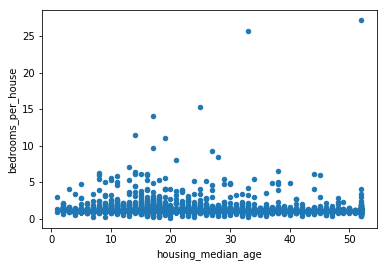

In [33]:
print(housing.columns)
h_trt['bedrooms_per_house']= housing_tr['total_bedrooms']/housing_tr['households']
h_trt.plot(kind='scatter', y='bedrooms_per_house', x='housing_median_age')

In [34]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
housing_cat = housing['ocean_proximity']
housing_cat_encoded = encoder.fit_transform(housing_cat)
housing_cat_encoded

array([1, 0, 3, ..., 0, 0, 4])

In [35]:
# The above is problematic, because ML will associate numerical closeness, which might not
# always be the case - for example when alphabetically ordered, but categorically distant
# (apples close to oranges categorically by fruit, but close to Alfred alphabetically)

print(encoder.classes_)

['<1H OCEAN' 'INLAND' 'ISLAND' 'NEAR BAY' 'NEAR OCEAN']


# Custom Transformers

In [36]:
# Therefore we can set up rules when encoding labels
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))
housing_cat_1hot

/Users/samuel/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [37]:
housing_cat_1hot.toarray()

array([[0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [38]:
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer(sparse_output=True)
housing_cat_1hot = encoder.fit_transform(housing_cat)
housing_cat_1hot.toarray()


array([[0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0],
       ...,
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1]])

In [39]:
# Lets automate some of those things we did above:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, household_ix = 3,4,5,6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    """ Bases:
    TransformerMixin adds fit_transform() method
    BaseEstimator adds get_params(), and set_params() methods
    """
    def __init__(self, add_bedroom_per_room = True): # no *args, or **kargs
        self.add_bedroom_per_room = add_bedroom_per_room
    
    def fit(self, X, y=None):
        return self  # Nothing else to do
    
    def transform(self, X, y=None):
        rooms_per_household = X[:,population_ix] / X[:, household_ix]
        population_per_houshold = X[:, population_ix] / X[:, household_ix]
        if self.add_bedroom_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_houshold, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_houshold]
        
attr_adder = CombinedAttributesAdder(add_bedroom_per_room=False)
housing_extra_atrribs = attr_adder.transform(housing.values)

In the above class, numpy's `np.c_` is used: which falttens multiple iterables in the form:
```python
np.c_[(HEAD), (BODY [, body2...]), (TAIL)]

[H,E,A,D, B,O,D,Y, T,A,I,L]
```

In [40]:
np.c_[np.array([1,2,3]), np.array([4,5,6])]

array([[1, 4],
       [2, 5],
       [3, 6]])

In [41]:
np.random.seed(seed=5228)
rnd_array = np.random.randint(0,10,20)
rnd_array

array([0, 3, 2, 4, 6, 7, 4, 9, 9, 3, 0, 2, 3, 1, 4, 7, 0, 8, 9, 4])

In [42]:
np.c_[np.array([[1,2,3]]),[rnd_array],np.array([[4,5,6]])]

array([[1, 2, 3, 0, 3, 2, 4, 6, 7, 4, 9, 9, 3, 0, 2, 3, 1, 4, 7, 0, 8, 9,
        4, 4, 5, 6]])

# Feature Scaling
*Normalising* data so that ML can compare values. Two common methods *min-max scaling* and *standardisation*

**NB - only fit scalers to training data**

### Min-max scaling
- Values are shifted and rescaled so they range from 0 - 1
- subtract the min value and divide by (max-min)
- eg using scikit-learn `sklearn.preprocessing.MinMaxSacaler` with hyperparameter 

### Standardisation
- Subtract mean value (zero mean), divide by variance
- not bounded to specific range
- less affected by outliers
- eg using scikit-learn `sklearn.preprocessing.StandardScaler`

### Categorical Pipeline
- eg using `sklearn.processing.LabelBinarizer`


# Transformation Pipeline
- defines a sequence of steps to transform data
- all but the last step must be transformers (ie must have `fit_transform()` method.
- Exposes same methods as final estimator
- eg using `sklearn.pipeline.Pipeline`



In [43]:
# Pipelines:
from sklearn.impute import SimpleImputer  # Imputer depreciated 0.20, removed in 0.22
from sklearn.impute import SimpleImputer as Imputer  #  Renamed so that I can use for tutorial
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeine = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

housing_num_tr = num_pipeine.fit_transform(housing_num)

### Join transformations into a single pipeline
- useful for combining a transformation containing both numerical and categorical data.
- eg using `sklearn.pipeline.FeatureUnion`
- a transformation pipeline becomes a transformer


In [44]:
# Full transformation pipeline
from sklearn.pipeline import FeatureUnion

from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X[self.attribute_names].values
    
class PipelineFriendlyLabelBinarizer(LabelBinarizer):
    """From 
    https://www.oreilly.com/catalog/errata.csp?isbn=0636920052289
    Page 68 code snippet under "And you can run the whole pipeline simply:
    """
    def fit_transform(self, X, y=None):
        return super(PipelineFriendlyLabelBinarizer, self).fit_transform(X)


num_attributes = list(housing_num)
cat_attributes = ['ocean_proximity']

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attributes)),
    ('imputer', SimpleImputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attributes)),
    ('label_binarizer', PipelineFriendlyLabelBinarizer()),  # Using fix above
])

full_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline),
])

housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

array([[ 0.30077491,  0.94578456, -1.16473862, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.81446651, -0.93416693, -0.84679512, ...,  0.        ,
         0.        ,  0.        ],
       [-1.39989339,  1.0021831 ,  1.85572467, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [ 0.62993652, -0.84956911, -0.21090811, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.69477138, -0.6756736 ,  1.53778116, ...,  0.        ,
         0.        ,  0.        ],
       [-0.44233235, -0.46887894,  1.53778116, ...,  0.        ,
         0.        ,  1.        ]])

In [45]:
housing_prepared.shape

(16512, 16)

# Selecting and training a model

In [46]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [47]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print('Predictions:\t', lin_reg.predict(some_data_prepared))
print('Labels:\t\t', list(some_labels))

Predictions:	 [ 98964.5 175564.5 169234.5  65086.5 116048.5]
Labels:		 [137500.0, 272000.0, 450000.0, 57000.0, 76500.0]


In [48]:
lin_reg

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

<Figure size 432x288 with 0 Axes>

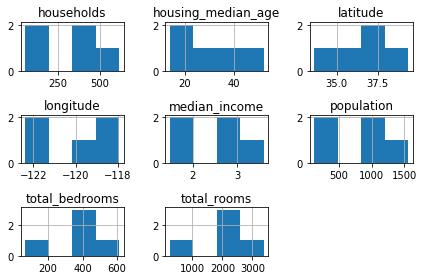

In [49]:
plt.figure()
some_data.hist(bins=4)
plt.tight_layout()

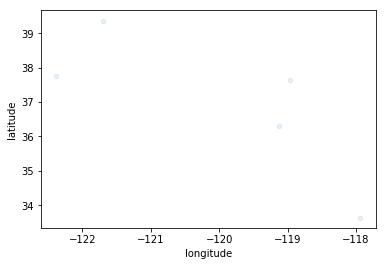

In [50]:
some_data.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1)

In [51]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68894.71277432596

# Trying a different model

In [52]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

seemingly - the above result would suggest that we have no error in our fitted function; however, this is because we have overfit the model. This raises another problem - which we need to address; that even though we have seperated our data, we need to use part of the training set for training and part of the model for validation. Thus:

# Better evalutation using cross validation:

`sklearn.model_selection.cross_val_score` 
- performs a *k-fold* cross validation by splitting the training data into 10 distinct folds
- trains / evalueates the decision tree model 10 times, choosing a different fold for evaluation every time and training on other 9 folds
- expexts a utility function

## Defn:
- **Utility Function**: +ve feedback, greater is better
- **Cost Function**: -ve feedback, lower is better


In [53]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                        scoring='neg_mean_squared_error', cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [54]:
# scores from a k-fold cross validation (k=10)
tree_rmse_scores

array([71091.33578551, 70599.88310011, 72679.4458728 , 72496.76442363,
       68328.62709789, 72512.10893874, 71133.65376899, 73202.28885628,
       72995.50919483, 71955.40970037])

In [55]:
def display_scores(scores):
    print('Scores:', scores)
    print('Mean:', scores.mean())
    print('Standard deviation:', scores.std())

display_scores(tree_rmse_scores)

Scores: [71091.33578551 70599.88310011 72679.4458728  72496.76442363
 68328.62709789 72512.10893874 71133.65376899 73202.28885628
 72995.50919483 71955.40970037]
Mean: 71699.50267391512
Standard deviation: 1397.2025205415966


## With Cross Validation:
 - you can estimate how well your model is going by checking the 

In [56]:
# Now lets do the same of Linear Regression:
lin_scores = cross_val_score(lin_reg,
                             housing_prepared,
                             housing_labels,
                             scoring="neg_mean_squared_error",
                             cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [67504.38226154 71407.82538879 67101.79643253 74900.82502859
 69321.30245471 71340.59157295 66940.73965911 66596.993166
 67355.23223641 69298.27176461]
Mean: 69176.79599652406
Standard deviation: 2540.3871023226943


In [57]:
# One model that does actually do better:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

# (Page 71 - something happening here)

housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

/Users/samuel/.virtualenvs/ml/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


22420.840855184615

# Pickle Your Work
```python
from sklearn.externals import joblib
joblib.dump(my_model, 'my_model.pkl')
```
then resurect it when you need it:
```python
my_model_loaded = joblib.load('my_model.pkl')
```

# Fine-Tune your model:
## Grid search
Use `sklearn.model_selection.GridSearchCV` to experiment with, and try out new hyperparameter values, and find the best one.

In [58]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3,10,30], 'max_features': [2,4,6,8]},
    {'bootstrap': [False], 'n_estimators': [3,10], 'max_features': [2,3,4]},
]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg,
                           param_grid,
                           cv=5,
                           scoring='neg_mean_squared_error')

grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [59]:
# The best combination of parameters can be accessed as so:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [60]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=None, oob_score=False,
           random_state=None, verbose=0, warm_start=False)

[[6.16920430e+04 8.00000000e+00 3.00000000e+01]
 [6.08055212e+04 8.00000000e+00 3.00000000e+01]
 [6.03681651e+04 6.00000000e+00 3.00000000e+01]
 [5.94403620e+04 6.00000000e+00 1.00000000e+01]
 [5.90732032e+04 6.00000000e+00 1.00000000e+01]
 [5.87803933e+04 4.00000000e+00 1.00000000e+01]
 [5.61650939e+04 4.00000000e+00 1.00000000e+01]
 [5.43490182e+04 4.00000000e+00 1.00000000e+01]
 [5.30869171e+04 4.00000000e+00 1.00000000e+01]
 [5.30157184e+04 4.00000000e+00 1.00000000e+01]
 [5.28807412e+04 3.00000000e+00 3.00000000e+00]
 [5.27639464e+04 3.00000000e+00 3.00000000e+00]
 [5.22155464e+04 2.00000000e+00 3.00000000e+00]
 [5.18011853e+04 2.00000000e+00 3.00000000e+00]
 [5.11294566e+04 2.00000000e+00 3.00000000e+00]
 [5.04958004e+04 2.00000000e+00 3.00000000e+00]
 [5.04733121e+04 2.00000000e+00 3.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]]


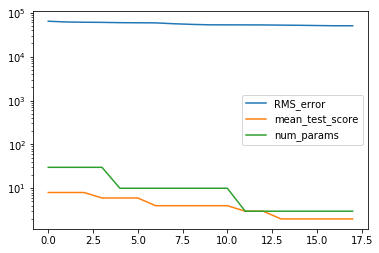

In [126]:
# And take a look at each of the scores:
cvres = grid_search.cv_results_
c_labels = ['RMS_error', 'mean_test_score', 'num_params']
xs = np.array([False,False,False])
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    x = np.sqrt(-mean_score)
#     print(x, params)
    y = [x, params['max_features'], params['n_estimators']]
    xs = np.vstack((xs,y))

xs[::-1].sort(axis=0)
print(xs[1:])
for i, y_label in enumerate(c_labels):
    plt.semilogy(xs[:-1,i], label=y_label)
plt.legend()